## TD Models

TD-learning family models:
1. <a href='#oneStepSARSA'> One-step SARSA </a>
2. n-step SARSA
3. Actor-critic:
    * Some Theory: <a href='http://incompleteideas.net/book/first/ebook/node66.html'>Actor-Critic Methods</a>
    * Possible Implementation: <a href='https://www.nature.com/articles/s41598-017-18004-7'> A hippocampo-cerebellar centred network for the learning and execution of sequence-based navigation </a>

In [7]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys

module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [8]:
# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [9]:
# Define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

In [139]:
ma.ru[1][-1]

11

### One-step SARSA <a id='#oneStepSARSA'></a>
Online TD-control algorithm which estimates state-action values, Q(s,a)
 - States: 127 maze nodes
 - Actions: 3 actions for each state (except for end nodes)
 - Rewards: 0 on all states except for 1 on the water port

Pseudocode
- Softmax action selection
- Action-value update: $Q(s,a) \leftarrow Q(s,a) + \alpha*(R + \gamma*R' - Q(s',a'))$

In [19]:
def get_SAnodemap(S,A):
    '''
    Generate an array with the same dimensions as state-action value look up table but with entries as node labels
    '''
    SAnodemap = np.ones((S+1,A)) * np.nan
    for node in np.arange(S):
        # Shallow level node available from current node
        if node%2 == 0:
            SAnodemap[node,0] = (node - 2) / 2
        elif node%2 == 1:
            SAnodemap[node,0] = (node - 1) / 2
        if SAnodemap[node,0] == -1:
            SAnodemap[node,0] = 127
        
        if node not in lv6_nodes:
            # Deeper level nodes available from current node
            SAnodemap[node,1] = node*2 + 1
            SAnodemap[node,2] = node*2 + 2
    
    # Nodes available from entry point
    SAnodemap[127,0] = np.nan
    SAnodemap[127,1] = 0
    SAnodemap[127,2] = np.nan
    
    return SAnodemap

In [140]:
def nodes2cell(state_hist_all):
    state_hist_cell = []
    state_hist_xy = {}
    ma=NewMaze(6)
    for epID, episode in enumerate(state_hist_all.values()):
        cells = []
        cells.extend([7])
        for id,node in enumerate(episode):
            if id != 0 and node != 127:
                if node > episode[id-1]: 
                    # if going to a deeper node
                    cells.extend(ma.ru[node])
                elif node < episode[id-1]: 
                    # if going to a shallower node
                    reverse_path = list(reversed(ma.ru[episode[id-1]]))
                    reverse_path = reverse_path + [ma.ru[node][-1]]
                    cells.extend(reverse_path[1:])
        home_path = list(reversed(ma.ru[0]))
        cells.extend(home_path[1:])  # cells from node 0 to maze exit
        state_hist_cell.append(cells)
        state_hist_xy[epID] = np.zeros((len(cells),2))
        state_hist_xy[epID][:,0] = ma.xc[cells]
        state_hist_xy[epID][:,1] = ma.yc[cells]
    return state_hist_cell, state_hist_xy

In [21]:
# Set environment parameters
S = 127
A = 3
RT = 1
Q_nodemap = get_SAnodemap(S,A)

# Set model parameters
alpha = 0.5  # learning rate
gamma = 0.9
beta = 20  # softmax exploration - exploitation
N = 500  # number of episodes to train over

# Initialize model parameters
Q = np.random.rand(S+1,A)  # state-action values
Q[127,:] = 0  # setting action-values of reward port to 0
Q[np.isnan(Q_nodemap)] = np.nan
state_hist_all = {}
total_reward = 0

for n in np.arange(N):
    # Initialize starting state,s0 to node 0 and selection action a0
    aprob = []
    choices = []
    s = 0
    for atype in np.arange(3):
        aprob.extend([np.exp(beta*Q[s,atype])/np.nansum(np.exp(beta*Q[s,:]))])
    a = np.random.choice([0,1,2],1,p=aprob)[0]
    state_hist = []
    
    # Begin episode
    while s!=127:
        # Record current state
        state_hist.extend([s])
        
        # Take action, observe reward and next state
        sprime = int(Q_nodemap[s,a])
        if sprime == 116:
            R = 1  # Receive a reward of 1 when transitioning to the reward port
            total_reward += 1
        else:
            R = 0
            
        # Choose next action, aprime from new state, sprime
        aprob = []
        choices = []
        for atype in np.arange(3):
            if not np.isnan(Q[sprime,atype]):
                aprob.extend([np.exp(Q[sprime,atype])/np.nansum(np.exp(Q[sprime,:]))])
                choices.extend([atype])
        aprime = np.random.choice(choices,1,p=aprob)[0]
        
        # Update action-value of previous state-action pair, Q[s,a]
        Q[s,a] += alpha * (R + gamma*Q[sprime,aprime] - Q[s,a])
        
        # Shift state and action values for the next time step
        a = aprime
        s = sprime
    state_hist.extend([s])
    state_hist_all[n] = state_hist

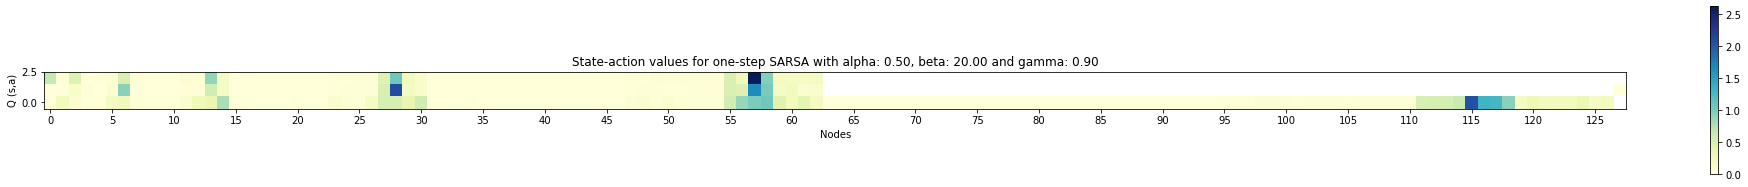

In [22]:
# Plotting state-action values
fig, ax = plt.subplots(figsize=(30,800))
axhandle = ax.imshow(np.transpose(Q),cmap='YlGnBu')
ax.invert_yaxis()
ax.set_ylabel('Q (s,a)')
ax.set_xticks(np.arange(0,127,5))
ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
ax.set_xlabel('Nodes')
ax.set_title('State-action values for one-step SARSA with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
fig.colorbar(axhandle,fraction=0.005)

In [151]:
def plot_trajectory(episode):
    from matplotlib.collections import LineCollection
    from matplotlib import cm

    # Draw the maze outline    
    fig,ax=plt.subplots(figsize=(6,6))
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=2,yflip=True,
              xhide=True,yhide=True,axes=ax)
    re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)

    #plt.axis('off'); # turn off the axes

    # Converting cell positions to x,y positions in the maze
    # ma.ce contains x,y positions for each cell
    if episode == 'all':
        for id, episode in enumerate(state_hist_xy):
            x = state_hist_xy[episode][:,0]
            y = state_hist_xy[episode][:,1]
            t = np.linspace(0,1,x.shape[0]) # your "time" variable

            # set up a list of (x,y) points
            points = np.array([x,y]).transpose().reshape(-1,1,2)

            # set up a list of segments
            segs = np.concatenate([points[:-1],points[1:]],axis=1)

            # make the collection of segments
            lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=2) # jet, viridis hot
            lc.set_array(t) # color the segments by our parameter

            # plot the collection
            lines=ax.add_collection(lc); # add the collection to the plot
    else:
        x = state_hist_xy[episode][:,0]
        y = state_hist_xy[episode][:,1]
        t = np.linspace(0,1,x.shape[0]) # your "time" variable

        # set up a list of (x,y) points
        points = np.array([x,y]).transpose().reshape(-1,1,2)

        # set up a list of segments
        segs = np.concatenate([points[:-1],points[1:]],axis=1)

        # make the collection of segments
        lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=2) # jet, viridis hot
        lc.set_array(t) # color the segments by our parameter

        # plot the collection
        lines=ax.add_collection(lc); # add the collection to the plot

    cax=fig.add_axes([1.05, 0.05, 0.05, 0.9])
    cbar=fig.colorbar(lines,cax=cax)
    cbar.set_ticks([0,1])
    cbar.set_ticklabels(['Entry','Exit'])
    cbar.ax.tick_params(labelsize=18)
    plt.show()

In [147]:
# Set trajectories for plotting
state_hist_cell, state_hist_xy = nodes2cell(state_hist_all)

In [ ]:
plot_trajectory('all')  # enter a single episode ID or enter 'all'